In [54]:
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext lab_black
import torchvision
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

random_seed = 1
torch.manual_seed(random_seed)

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [55]:
batch_size = 64

In [56]:
# To normalize we need the mean and std of our dataset
from tensorflow.keras.datasets import mnist

# Load,and set train and test data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
dataset = np.concatenate((X_train, X_test), axis=0)
dataset = dataset / 255
dataset_mean = dataset.mean()
dataset_std = dataset.std()
print(f"mean:{round(dataset_mean,4)}")
print(f"standard deviation:{round(dataset_std,4)}")

mean:0.1309
standard deviation:0.3084


In [57]:
# Load,and set train and test data
# Normalize the dataset
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "/files/",
        train=True,
        download=True,
        transform=torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((dataset_mean,), (dataset_std,)),
            ]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "/files/",
        train=False,
        download=True,
        transform=torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((dataset_mean,), (dataset_std,)),
            ]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

In [58]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

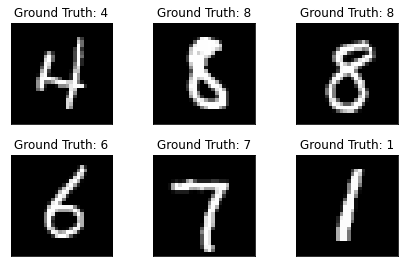

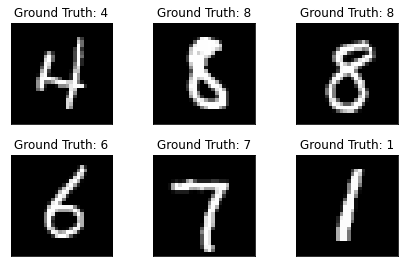

In [59]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap="gray", interpolation="none")
    plt.title(f"Ground Truth: {example_targets[i]}")
    plt.xticks([])
    plt.yticks([])
fig

In [60]:
for batch, (X, y) in enumerate(train_loader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break

Batch: 1
X shape: torch.Size([64, 1, 28, 28])
y shape: torch.Size([64])


In [71]:
class NeuralNetwork(nn.Module):
    def __init__(self) -> None:
        super(NeuralNetwork, self).__init__()
        # Default padding=0 and stride =1
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # input shape: [64, 1, 28, 28]
        # output shape: [64, 10, 24, 24]
        x = F.relu(F.max_pool2d(self.conv1(x), 2))

        # input shape: [64, 10, 12, 12] (stride for pooling counts as kernel size)
        # output shape: [64, 20, 8, 8]
        x = F.relu(F.max_pool2d(self.conv2_dropout(self.conv2(x)), 2))
        
        # flatten input shape: [64, 20, 4, 4]
        # output shape: [64, 320]
        x = x.view(-1, 320)
        
        # input shape: [64, 320]
        # output shape: [64, 50]
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        
        # input shape: [64, 50]
        # output shape: [64, 10]
        x = self.fc2(x)
        softmax = F.log_softmax(x, 1)
        return softmax

In [98]:
class NeuralNetwork(nn.Module):
    def __init__(self) -> None:
        super(NeuralNetwork, self).__init__()
        # Default padding=0 and stride =1
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)
        self.conv2 = nn.Conv2d(20, 30, kernel_size=5)
        self.conv2_dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(480, 60)
        self.fc2 = nn.Linear(60, 10)

    def forward(self, x):
        # input shape: [64, 1, 28, 28]
        # output shape: [64, 10, 24, 24]
        x = F.relu(F.max_pool2d(self.conv1(x), 2))

        # input shape: [64, 10, 12, 12] (stride for pooling counts as kernel size)
        # output shape: [64, 20, 8, 8]
        x = F.relu(F.max_pool2d(self.conv2_dropout(self.conv2(x)), 2))
        # flatten input shape: [64, 20, 4, 4]
        # output shape: [64, 320]
        x = x.view(-1, 480)

        # input shape: [64, 320]
        # output shape: [64, 50]
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)

        # input shape: [64, 50]
        # output shape: [64, 10]
        x = self.fc2(x)
        softmax = F.log_softmax(x, 1)
        return softmax

In [99]:
# Hyperparameters
epochs = 100
learning_rate = 0.01
momentum = 0.5
log_interval = 10

network = NeuralNetwork()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [100]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(epochs + 1)]

In [101]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} ({100.0 * batch_idx / len(train_loader)}%)]\tLoss: {loss.item()}",
            )
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset))
            )
            torch.save(network.state_dict(), "./results/model.pth")
            torch.save(optimizer.state_dict(), "./results/optimizer.pth")

In [102]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(
        f"\nTest set: Avg. loss: {test_loss}, Accuracy: {correct}/{len(test_loader.dataset)} ({100.0 * correct / len(test_loader.dataset)}%)\n"
    )

In [111]:
test()
for epoch in range(1, epochs + 1):
    train(epoch)
    test()

c:\Users\jsandh\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.06889941681921483, Accuracy: 9778/10000 (97.77999877929688%)

Train Epoch: 1 [0/60000 (0.0%)]	Loss: 0.15788458287715912
Train Epoch: 1 [640/60000 (1.0660980810234542%)]	Loss: 0.20361953973770142
Train Epoch: 1 [1280/60000 (2.1321961620469083%)]	Loss: 0.12890039384365082
Train Epoch: 1 [1920/60000 (3.1982942430703623%)]	Loss: 0.27999523282051086
Train Epoch: 1 [2560/60000 (4.264392324093817%)]	Loss: 0.32116708159446716
Train Epoch: 1 [3200/60000 (5.330490405117271%)]	Loss: 0.4109933376312256
Train Epoch: 1 [3840/60000 (6.3965884861407245%)]	Loss: 0.18717557191848755
Train Epoch: 1 [4480/60000 (7.462686567164179%)]	Loss: 0.26569685339927673
Train Epoch: 1 [5120/60000 (8.528784648187633%)]	Loss: 0.1343555748462677
Train Epoch: 1 [5760/60000 (9.594882729211088%)]	Loss: 0.16792520880699158
Train Epoch: 1 [6400/60000 (10.660980810234541%)]	Loss: 0.1803053915500641
Train Epoch: 1 [7040/60000 (11.727078891257996%)]	Loss: 0.1850898712873459
Train Epoch: 1 [7680/60000 (12

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.plot(train_counter, train_losses, color="blue")
plt.scatter(test_counter, test_losses, color="red")
plt.legend(["Train Loss", "Test Loss"], loc="upper right")
plt.xlabel("number of training examples seen")
plt.ylabel("negative log likelihood loss")
fig.show()

In [ ]:
with torch.no_grad():
    output = network(example_data)

In [ ]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap="gray", interpolation="none")
    plt.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
fig

In [ ]:
#Continued training
continued_network = NeuralNetwork()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [ ]:
network_state_dict = torch.load("./results/model.pth")
continued_network.load_state_dict(network_state_dict)
optimizer_state_dict = torch.load("./results/optimizer.pth")
continued_optimizer.load_state_dict(optimizer_state_dict)
